In [19]:
import pickle
from collections import OrderedDict
import scipy.stats
from pylab import * 
import seaborn as sns
from IPython.display import display
import pandas
from skbio.sequence import DNA
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/lib/analysis_lib.ipynb"

In [20]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks


In [21]:
NMER = 6

In [22]:
args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1_100.alignment_true_events.pickle",
    "model_out": "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1.model.computed.pickle"
}

In [23]:
true_events = pickle.load(open(args["true_events"], 'rb'))

### make dict with all kmers 

In [24]:
all_kmers = mk_kmer_dict(NMER)
ev_map = mk_event_map(true_events, all_kmers)

# Analysis

## compare features

In [25]:
def sorted_boxplot(ordered_dict, ylim=None):
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
    map2 = OrderedDict(sorted(ordered_dict.items(), key=lambda x : 0 if len(x[1]) == 0 else np.mean(x[1])))
    fig, ax = subplots(figsize = (15, 5))
    boxplot(list(map2.values()))
    ax.set_xticklabels(list(map2.keys()), rotation=90, fontsize=8)
    if ylim is not None:
        ax.set_ylim(ylim)
    fig.show()

In [26]:
def make_feature_map(process_event, ev_map):
    """
    Args:
        process_events: function(strand, event) with 
            strand in ["template", "complement"] and 
            event containing the event features
        ev_map: dict kmer -> list of correct events
            
    Returns: 
        dict kmer -> list_with_features
    """
    fmap = {kmer: [] for kmer in ev_map.keys()}
    for kmer, events in ev_map.items():
        kmer_c = str(DNA(kmer).reverse_complement())
        d = {"template" : [], "complement" : []}
        for ev in events: 
            for t in d.keys():
                feature = process_event(t, ev)
                if not np.isnan(feature): 
                    d[t].append(feature)

        fmap[kmer].extend(d["template"])
        #fmap[kmer_c].extend(d["complement"])
    return fmap

### mean pA

In [27]:
def feature_pa(t, ev): 
    return ev["{0}.mean".format(t)]

pa_map = make_feature_map(feature_pa, ev_map)

/home/ibis/gregor.sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


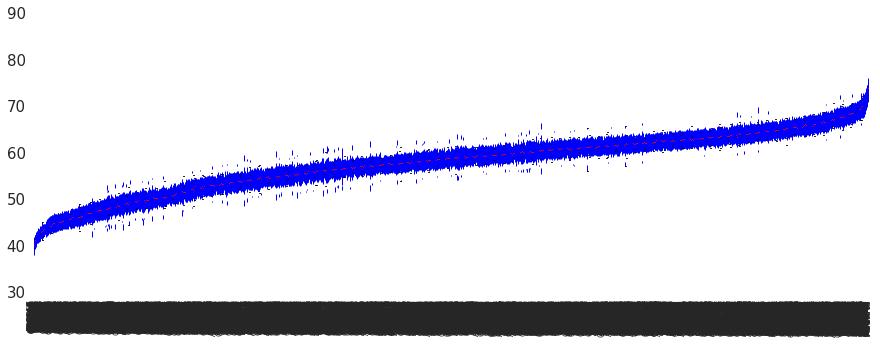

In [28]:
sorted_boxplot(pa_map)

### mean stdev

In [29]:
def feature_stdv(t, ev): 
    return ev["{0}.stdv".format(t)]

stdv_map = make_feature_map(feature_stdv, ev_map)

In [30]:
# sorted_boxplot(stdv_map)

### mean length

In [31]:
def length_feature(t, ev):
    return ev["{0}.length".format(t)]

len_map = make_feature_map(length_feature, ev_map)

In [32]:
# mean([mean(x) for x in len_map.values()])

In [33]:
# sorted_boxplot(len_map, ylim=(0,600))

## outputs for hmm

In [34]:
model = []
for kmer in all_kmers: 
    entry = {
        "kmer": kmer,
        "level_mean": mean(pa_map[kmer]),
        "level_stdv": std(pa_map[kmer]),
        "sd_mean": mean(stdv_map[kmer]),
        "sd_stdv": std(stdv_map[kmer]),
        "weight": 1.
    }
    model.append(entry)
model = pandas.DataFrame(model)

/home/ibis/gregor.sturm/bin/anaconda3/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/ibis/gregor.sturm/bin/anaconda3/lib/python3.4/site-packages/numpy/core/_methods.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [35]:
models = {}
models["/opt/chimaera/model/r7.3_e6_70bps_6mer/template_median68pA.model"] = model

In [36]:
pickle.dump(models, open(args["model_out"], 'wb'), protocol=2)